In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.enable_eager_execution()

import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization, SpatialDropout2D, LeakyReLU, Conv2D, AveragePooling2D, Dropout, Flatten, Lambda, Dense, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(1)


Using TensorFlow backend.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22#43#22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14#28#14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16#32#16
        self.data_dir = 'E:\Skelnet2D\data\SHREC\\'
C = Config()

In [4]:
# model
dropout_probability = 0.1
duration = 32
n_classes = 28
n_channels = 22  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints
filters = 64

In [5]:
def c2D(x,filters,kernel):
    x = Conv2D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = SpatialDropout2D(dropout_probability)(x)
    return x

def block(x,filters):
    x = c2D(x,filters,3)
    x = c2D(x,filters,3)
    return x
    
def d2D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

In [6]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    model_input = Input(shape=(duration, n_channels,3))
    
    high = c2D(model_input, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    high = c2D(high, filters*2,7)
    high = MaxPooling2D((2, 2), padding='same')(high)
    
    low = c2D(model_input, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    low = c2D(low, filters*2,3)
    low = MaxPooling2D((2, 2), padding='same')(low)
    
    ap_residual = MaxPooling2D((2, 2), padding='same', input_shape=(32,n_channels, 1))(model_input)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    ap_residual = MaxPooling2D((2, 2), padding='same')(ap_residual)
    
    channel_output = concatenate([low,high,ap_residual])
    features = block(channel_output,filters*2)
    features = block(channel_output,filters*2)
    features = GlobalMaxPool2D()(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    features = d2D(features,128)
    features = Dropout(dropout_probability)(features)
    model_output = Dense(units=n_classes, activation='softmax')(features)
        
    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [7]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 22, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 22, 128)  3456        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 22, 128)  18816       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 22, 128)  512         conv2d_3[0][0]                   
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 4, 3, 128)    147456      spatial_dropout2d_8[0][0]        
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 4, 3, 128)    512         conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 4, 3, 128)    0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
spatial_dropout2d_9 (SpatialDro (None, 4, 3, 128)    0           leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 128)          0           spatial_dropout2d_9[0][0]        
__________

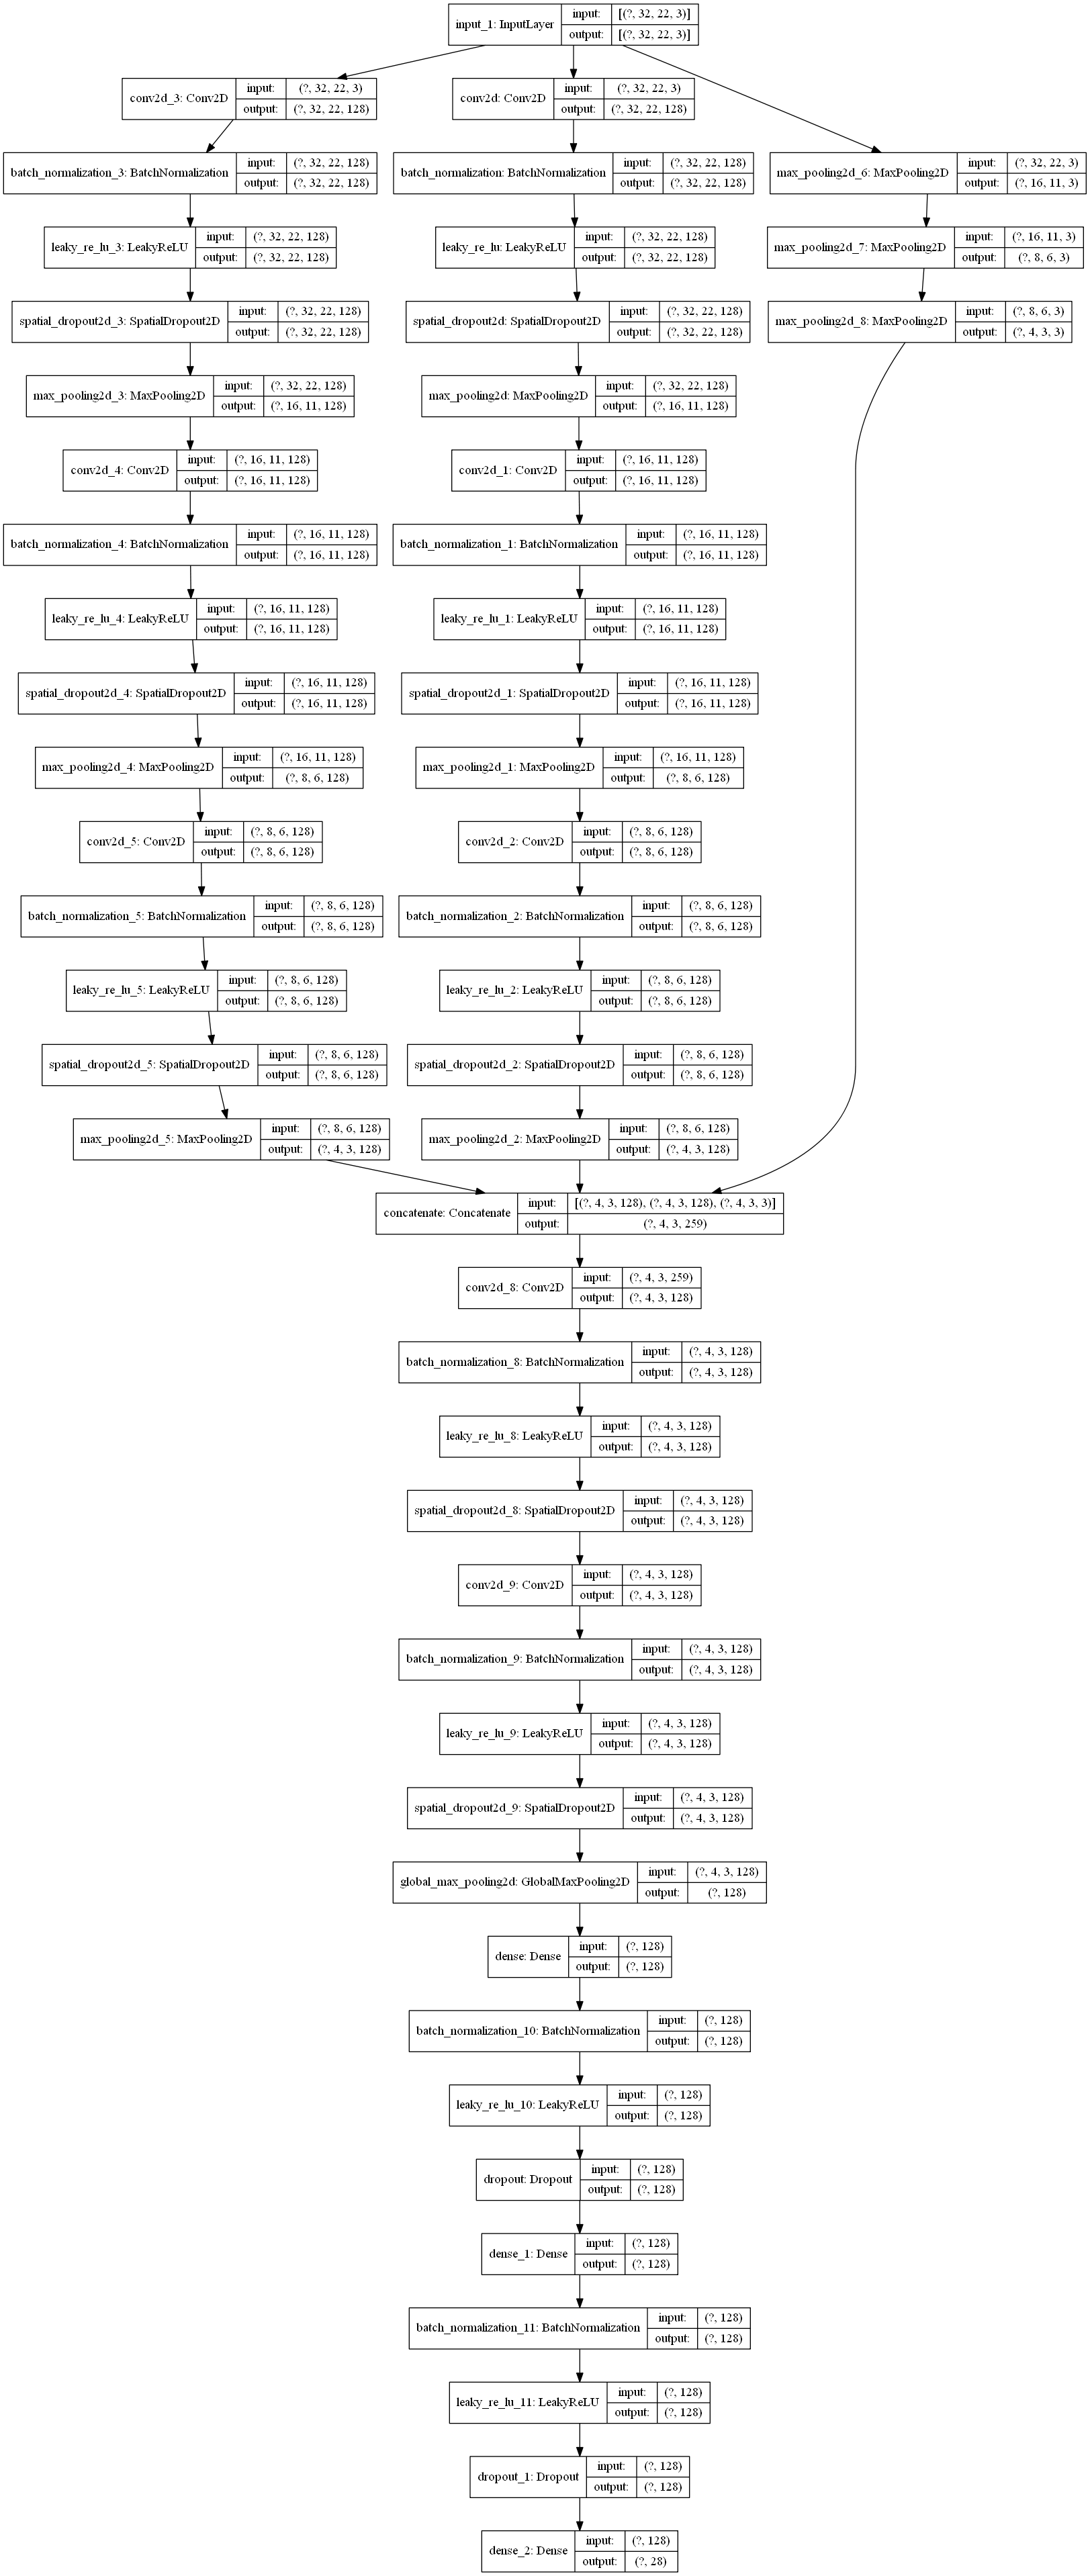

In [9]:
plot_model(model, to_file='model.png', show_shapes=True)

In [10]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

In [11]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Train['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

  2%|█▌                                                                             | 40/1960 [00:00<00:09, 198.49it/s]C:\Users\Joseph\Anaconda3\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
100%|█████████████████████████████████████████████████████████████████████████████| 1960/1960 [00:09<00:00, 203.52it/s]


In [12]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_fine)
    label[Test['fine_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|███████████████████████████████████████████████████████████████████████████████| 840/840 [00:04<00:00, 207.03it/s]


In [13]:
"""blank = X_1
blank_test = X_test_1
blank = np.zeros((1960,32,43,3))
blank_test = np.zeros((840,32,43,3))
list = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]
count = 0
for i in range(0,X_1.shape[0]):
    for j in range(0, X_1.shape[1]):
        count = 0
        for k in list:
            blank[i][j][count] = X_1[i][j][k-1]
            count = count + 1
count = 0
for i in range(0, X_test_1.shape[0]):
    for j in range(0, X_test_1.shape[1]):
        count = 0
        for k in list:
            blank_test[i][j][count] = X_test_1[i][j][k-1]
            count = count + 1
X_1 = blank
X_test_1 = blank_test"""

'blank = X_1\nblank_test = X_test_1\nblank = np.zeros((1960,32,43,3))\nblank_test = np.zeros((840,32,43,3))\nlist = [2,3,4,5,6,5,4,3,2,7,8,9,10,9,8,7,2,1,2,11,12,13,14,13,12,11,2,15,16,17,18,17,16,15,2,19,20,21,22,21,20,19,2]\ncount = 0\nfor i in range(0,X_1.shape[0]):\n    for j in range(0, X_1.shape[1]):\n        count = 0\n        for k in list:\n            blank[i][j][count] = X_1[i][j][k-1]\n            count = count + 1\ncount = 0\nfor i in range(0, X_test_1.shape[0]):\n    for j in range(0, X_test_1.shape[1]):\n        count = 0\n        for k in list:\n            blank_test[i][j][count] = X_test_1[i][j][k-1]\n            count = count + 1\nX_1 = blank\nX_test_1 = blank_test'

In [14]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# Start the training

# ...with an existing validation set:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=1e-8)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_Skel2D.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_1, Y, validation_data=(X_test_1, Y_test), epochs=10000, batch_size=32, callbacks=[reduce_lr,es,mc])

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Train on 1960 samples, validate on 840 samples
Epoch 1/10000
1952/1960 [============================>.] - ETA: 1:43 - loss: 3.8125 - acc: 0.0000e+0 - ETA: 58s - loss: 3.7933 - acc: 0.0312    - ETA: 43s - loss: 3.6552 - acc: 0.03 - ETA: 35s - loss: 3.6171 - acc: 0.04 - ETA: 31s - loss: 3.5791 - acc: 0.05 - ETA: 27s - loss: 3.5051 - acc: 0.06 - ETA: 25s - loss: 3.4662 - acc: 0.06 - ETA: 23s - loss: 3.4359 - acc: 0.07 - ETA: 21s - loss: 3.4001 - acc: 0.07 - ETA: 20s - loss: 3.3543 - acc: 0.09 - ETA: 19s - loss: 3.3165 - acc: 0.10 - ETA: 18s - loss: 3.3051 - acc: 0.10 - ETA: 17s - loss: 3.2726 - acc: 0.11 - ETA: 16s - loss: 3.2594 - acc: 0.11 - ETA: 16s - loss: 3.2286 - acc: 0.11 - ETA: 15s - loss: 3.1975 - acc: 0.12 - ETA: 15s - loss: 3.1696 - acc: 0.13 - ETA: 14s - loss: 3.1562 - acc: 0.13 - ETA: 13s - loss: 3.1281 - acc: 0.14 - ETA: 13s - loss: 3.0980 - acc: 0.14 - ETA: 12s - loss: 3.0708 - acc: 0.15 - ETA: 12s - loss: 3.0473 - acc: 0.15 - ETA: 12s - loss: 3.0323 - acc: 0.15 - ETA: 11s 

1952/1960 [============================>.] - ETA: 15s - loss: 0.7851 - acc: 0.75 - ETA: 15s - loss: 0.7536 - acc: 0.79 - ETA: 15s - loss: 0.6754 - acc: 0.81 - ETA: 14s - loss: 0.6921 - acc: 0.78 - ETA: 14s - loss: 0.6550 - acc: 0.81 - ETA: 14s - loss: 0.6640 - acc: 0.80 - ETA: 14s - loss: 0.6662 - acc: 0.80 - ETA: 13s - loss: 0.6587 - acc: 0.82 - ETA: 13s - loss: 0.6528 - acc: 0.81 - ETA: 13s - loss: 0.6290 - acc: 0.82 - ETA: 13s - loss: 0.6234 - acc: 0.82 - ETA: 13s - loss: 0.6569 - acc: 0.81 - ETA: 12s - loss: 0.6796 - acc: 0.79 - ETA: 12s - loss: 0.6848 - acc: 0.79 - ETA: 12s - loss: 0.6766 - acc: 0.80 - ETA: 12s - loss: 0.6739 - acc: 0.80 - ETA: 11s - loss: 0.6717 - acc: 0.80 - ETA: 11s - loss: 0.6653 - acc: 0.80 - ETA: 11s - loss: 0.6658 - acc: 0.80 - ETA: 11s - loss: 0.6621 - acc: 0.81 - ETA: 10s - loss: 0.6549 - acc: 0.81 - ETA: 10s - loss: 0.6584 - acc: 0.81 - ETA: 10s - loss: 0.6558 - acc: 0.81 - ETA: 10s - loss: 0.6525 - acc: 0.81 - ETA: 9s - loss: 0.6536 - acc: 0.8163 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.3012 - acc: 0.87 - ETA: 15s - loss: 0.3939 - acc: 0.87 - ETA: 15s - loss: 0.4157 - acc: 0.89 - ETA: 14s - loss: 0.3780 - acc: 0.92 - ETA: 14s - loss: 0.4035 - acc: 0.90 - ETA: 14s - loss: 0.3860 - acc: 0.91 - ETA: 14s - loss: 0.4239 - acc: 0.90 - ETA: 14s - loss: 0.4790 - acc: 0.87 - ETA: 14s - loss: 0.4583 - acc: 0.87 - ETA: 13s - loss: 0.4427 - acc: 0.88 - ETA: 13s - loss: 0.4396 - acc: 0.88 - ETA: 13s - loss: 0.4394 - acc: 0.88 - ETA: 13s - loss: 0.4359 - acc: 0.87 - ETA: 12s - loss: 0.4554 - acc: 0.87 - ETA: 12s - loss: 0.4455 - acc: 0.87 - ETA: 12s - loss: 0.4506 - acc: 0.87 - ETA: 12s - loss: 0.4493 - acc: 0.87 - ETA: 11s - loss: 0.4326 - acc: 0.88 - ETA: 11s - loss: 0.4260 - acc: 0.88 - ETA: 11s - loss: 0.4357 - acc: 0.88 - ETA: 10s - loss: 0.4338 - acc: 0.88 - ETA: 10s - loss: 0.4385 - acc: 0.88 - ETA: 10s - loss: 0.4321 - acc: 0.88 - ETA: 9s - loss: 0.4280 - acc: 0.8854 - ETA: 9s - loss: 0.4205 - acc: 0.888 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.4047 - acc: 0.90 - ETA: 15s - loss: 0.2888 - acc: 0.93 - ETA: 15s - loss: 0.2721 - acc: 0.93 - ETA: 14s - loss: 0.2870 - acc: 0.92 - ETA: 14s - loss: 0.2718 - acc: 0.93 - ETA: 14s - loss: 0.2774 - acc: 0.91 - ETA: 13s - loss: 0.2797 - acc: 0.92 - ETA: 13s - loss: 0.2730 - acc: 0.92 - ETA: 13s - loss: 0.2772 - acc: 0.92 - ETA: 13s - loss: 0.2712 - acc: 0.92 - ETA: 12s - loss: 0.2781 - acc: 0.92 - ETA: 12s - loss: 0.2712 - acc: 0.92 - ETA: 12s - loss: 0.2669 - acc: 0.92 - ETA: 12s - loss: 0.2650 - acc: 0.92 - ETA: 11s - loss: 0.2675 - acc: 0.92 - ETA: 11s - loss: 0.2892 - acc: 0.91 - ETA: 11s - loss: 0.2813 - acc: 0.91 - ETA: 11s - loss: 0.2900 - acc: 0.91 - ETA: 11s - loss: 0.2944 - acc: 0.91 - ETA: 10s - loss: 0.3021 - acc: 0.91 - ETA: 10s - loss: 0.2984 - acc: 0.91 - ETA: 10s - loss: 0.2908 - acc: 0.91 - ETA: 10s - loss: 0.2914 - acc: 0.91 - ETA: 9s - loss: 0.2908 - acc: 0.9193 - ETA: 9s - loss: 0.3142 - acc: 0.915 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.3245 - acc: 0.90 - ETA: 15s - loss: 0.2913 - acc: 0.87 - ETA: 15s - loss: 0.2908 - acc: 0.87 - ETA: 14s - loss: 0.2689 - acc: 0.89 - ETA: 14s - loss: 0.2296 - acc: 0.91 - ETA: 14s - loss: 0.2859 - acc: 0.91 - ETA: 13s - loss: 0.2840 - acc: 0.91 - ETA: 13s - loss: 0.2869 - acc: 0.90 - ETA: 13s - loss: 0.2874 - acc: 0.90 - ETA: 13s - loss: 0.2707 - acc: 0.91 - ETA: 12s - loss: 0.2811 - acc: 0.91 - ETA: 12s - loss: 0.2833 - acc: 0.90 - ETA: 12s - loss: 0.2747 - acc: 0.90 - ETA: 12s - loss: 0.2726 - acc: 0.91 - ETA: 11s - loss: 0.2706 - acc: 0.91 - ETA: 11s - loss: 0.2623 - acc: 0.91 - ETA: 11s - loss: 0.2565 - acc: 0.91 - ETA: 11s - loss: 0.2572 - acc: 0.91 - ETA: 10s - loss: 0.2547 - acc: 0.91 - ETA: 10s - loss: 0.2571 - acc: 0.91 - ETA: 10s - loss: 0.2551 - acc: 0.91 - ETA: 10s - loss: 0.2484 - acc: 0.92 - ETA: 9s - loss: 0.2424 - acc: 0.9226 - ETA: 9s - loss: 0.2429 - acc: 0.921 - ETA: 9s - loss: 0.2388 - acc: 0.925 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.1944 - acc: 0.90 - ETA: 17s - loss: 0.1373 - acc: 0.95 - ETA: 16s - loss: 0.1199 - acc: 0.95 - ETA: 16s - loss: 0.1572 - acc: 0.95 - ETA: 15s - loss: 0.1548 - acc: 0.95 - ETA: 15s - loss: 0.1455 - acc: 0.96 - ETA: 14s - loss: 0.1746 - acc: 0.95 - ETA: 14s - loss: 0.1655 - acc: 0.95 - ETA: 13s - loss: 0.1574 - acc: 0.95 - ETA: 13s - loss: 0.1594 - acc: 0.95 - ETA: 13s - loss: 0.1641 - acc: 0.95 - ETA: 13s - loss: 0.1699 - acc: 0.95 - ETA: 12s - loss: 0.1732 - acc: 0.94 - ETA: 12s - loss: 0.1804 - acc: 0.94 - ETA: 12s - loss: 0.1732 - acc: 0.94 - ETA: 11s - loss: 0.1908 - acc: 0.93 - ETA: 11s - loss: 0.1922 - acc: 0.93 - ETA: 11s - loss: 0.2055 - acc: 0.93 - ETA: 10s - loss: 0.1996 - acc: 0.93 - ETA: 10s - loss: 0.1985 - acc: 0.93 - ETA: 10s - loss: 0.1965 - acc: 0.93 - ETA: 10s - loss: 0.1924 - acc: 0.93 - ETA: 9s - loss: 0.2022 - acc: 0.9348 - ETA: 9s - loss: 0.1990 - acc: 0.936 - ETA: 9s - loss: 0.1972 - acc: 0.937 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.0333 - acc: 1.00 - ETA: 16s - loss: 0.1216 - acc: 0.96 - ETA: 16s - loss: 0.1851 - acc: 0.95 - ETA: 15s - loss: 0.1938 - acc: 0.95 - ETA: 15s - loss: 0.1739 - acc: 0.95 - ETA: 15s - loss: 0.1809 - acc: 0.94 - ETA: 14s - loss: 0.1834 - acc: 0.93 - ETA: 14s - loss: 0.1696 - acc: 0.94 - ETA: 14s - loss: 0.1687 - acc: 0.94 - ETA: 13s - loss: 0.1665 - acc: 0.94 - ETA: 13s - loss: 0.1665 - acc: 0.94 - ETA: 13s - loss: 0.1576 - acc: 0.94 - ETA: 12s - loss: 0.1566 - acc: 0.94 - ETA: 12s - loss: 0.1683 - acc: 0.93 - ETA: 12s - loss: 0.1731 - acc: 0.93 - ETA: 12s - loss: 0.1702 - acc: 0.93 - ETA: 11s - loss: 0.1658 - acc: 0.94 - ETA: 11s - loss: 0.1597 - acc: 0.94 - ETA: 11s - loss: 0.1581 - acc: 0.94 - ETA: 11s - loss: 0.1615 - acc: 0.94 - ETA: 10s - loss: 0.1606 - acc: 0.94 - ETA: 10s - loss: 0.1626 - acc: 0.94 - ETA: 10s - loss: 0.1662 - acc: 0.94 - ETA: 10s - loss: 0.1671 - acc: 0.94 - ETA: 9s - loss: 0.1638 - acc: 0.9463 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0279 - acc: 1.00 - ETA: 15s - loss: 0.1442 - acc: 0.98 - ETA: 14s - loss: 0.2156 - acc: 0.96 - ETA: 14s - loss: 0.1794 - acc: 0.96 - ETA: 14s - loss: 0.1700 - acc: 0.96 - ETA: 14s - loss: 0.1611 - acc: 0.96 - ETA: 13s - loss: 0.1611 - acc: 0.95 - ETA: 13s - loss: 0.1541 - acc: 0.96 - ETA: 13s - loss: 0.1518 - acc: 0.96 - ETA: 13s - loss: 0.1448 - acc: 0.96 - ETA: 12s - loss: 0.1418 - acc: 0.96 - ETA: 12s - loss: 0.1475 - acc: 0.96 - ETA: 12s - loss: 0.1426 - acc: 0.96 - ETA: 12s - loss: 0.1429 - acc: 0.96 - ETA: 11s - loss: 0.1366 - acc: 0.96 - ETA: 11s - loss: 0.1539 - acc: 0.96 - ETA: 11s - loss: 0.1505 - acc: 0.96 - ETA: 11s - loss: 0.1469 - acc: 0.96 - ETA: 10s - loss: 0.1444 - acc: 0.96 - ETA: 10s - loss: 0.1400 - acc: 0.96 - ETA: 10s - loss: 0.1620 - acc: 0.96 - ETA: 10s - loss: 0.1582 - acc: 0.96 - ETA: 9s - loss: 0.1572 - acc: 0.9647 - ETA: 9s - loss: 0.1548 - acc: 0.964 - ETA: 9s - loss: 0.1502 - acc: 0.966 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0959 - acc: 0.96 - ETA: 15s - loss: 0.0668 - acc: 0.98 - ETA: 15s - loss: 0.0716 - acc: 0.96 - ETA: 14s - loss: 0.1109 - acc: 0.96 - ETA: 14s - loss: 0.1961 - acc: 0.93 - ETA: 14s - loss: 0.1865 - acc: 0.93 - ETA: 14s - loss: 0.2218 - acc: 0.92 - ETA: 13s - loss: 0.2545 - acc: 0.91 - ETA: 13s - loss: 0.2571 - acc: 0.92 - ETA: 13s - loss: 0.2430 - acc: 0.92 - ETA: 12s - loss: 0.2270 - acc: 0.93 - ETA: 12s - loss: 0.2109 - acc: 0.93 - ETA: 12s - loss: 0.2028 - acc: 0.93 - ETA: 12s - loss: 0.1991 - acc: 0.93 - ETA: 11s - loss: 0.2139 - acc: 0.93 - ETA: 11s - loss: 0.2076 - acc: 0.93 - ETA: 11s - loss: 0.2014 - acc: 0.93 - ETA: 11s - loss: 0.2097 - acc: 0.93 - ETA: 10s - loss: 0.2177 - acc: 0.93 - ETA: 10s - loss: 0.2132 - acc: 0.93 - ETA: 10s - loss: 0.2063 - acc: 0.93 - ETA: 10s - loss: 0.2048 - acc: 0.93 - ETA: 9s - loss: 0.2016 - acc: 0.9375 - ETA: 9s - loss: 0.1970 - acc: 0.938 - ETA: 9s - loss: 0.1996 - acc: 0.938 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0367 - acc: 1.00 - ETA: 16s - loss: 0.0354 - acc: 1.00 - ETA: 16s - loss: 0.0360 - acc: 1.00 - ETA: 16s - loss: 0.0319 - acc: 1.00 - ETA: 15s - loss: 0.0290 - acc: 1.00 - ETA: 15s - loss: 0.0268 - acc: 1.00 - ETA: 14s - loss: 0.0674 - acc: 0.98 - ETA: 14s - loss: 0.0624 - acc: 0.98 - ETA: 14s - loss: 0.0593 - acc: 0.98 - ETA: 13s - loss: 0.0670 - acc: 0.98 - ETA: 13s - loss: 0.0667 - acc: 0.98 - ETA: 13s - loss: 0.0625 - acc: 0.98 - ETA: 12s - loss: 0.0606 - acc: 0.98 - ETA: 12s - loss: 0.0613 - acc: 0.98 - ETA: 12s - loss: 0.0599 - acc: 0.98 - ETA: 11s - loss: 0.0583 - acc: 0.98 - ETA: 11s - loss: 0.0577 - acc: 0.98 - ETA: 11s - loss: 0.0574 - acc: 0.98 - ETA: 11s - loss: 0.0609 - acc: 0.98 - ETA: 10s - loss: 0.0606 - acc: 0.98 - ETA: 10s - loss: 0.0624 - acc: 0.98 - ETA: 10s - loss: 0.0681 - acc: 0.98 - ETA: 10s - loss: 0.0657 - acc: 0.98 - ETA: 9s - loss: 0.0649 - acc: 0.9857 - ETA: 9s - loss: 0.0647 - acc: 0.986 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0283 - acc: 1.00 - ETA: 15s - loss: 0.0281 - acc: 1.00 - ETA: 14s - loss: 0.0223 - acc: 1.00 - ETA: 14s - loss: 0.0231 - acc: 1.00 - ETA: 14s - loss: 0.0312 - acc: 0.99 - ETA: 14s - loss: 0.0455 - acc: 0.98 - ETA: 13s - loss: 0.0418 - acc: 0.99 - ETA: 13s - loss: 0.0382 - acc: 0.99 - ETA: 13s - loss: 0.0391 - acc: 0.98 - ETA: 13s - loss: 0.0365 - acc: 0.99 - ETA: 12s - loss: 0.0345 - acc: 0.99 - ETA: 12s - loss: 0.0340 - acc: 0.99 - ETA: 12s - loss: 0.0339 - acc: 0.99 - ETA: 12s - loss: 0.0361 - acc: 0.99 - ETA: 11s - loss: 0.0393 - acc: 0.98 - ETA: 11s - loss: 0.0385 - acc: 0.99 - ETA: 11s - loss: 0.0367 - acc: 0.99 - ETA: 10s - loss: 0.0413 - acc: 0.98 - ETA: 10s - loss: 0.0406 - acc: 0.98 - ETA: 10s - loss: 0.0406 - acc: 0.98 - ETA: 10s - loss: 0.0394 - acc: 0.98 - ETA: 9s - loss: 0.0393 - acc: 0.9901 - ETA: 9s - loss: 0.0405 - acc: 0.989 - ETA: 9s - loss: 0.0402 - acc: 0.989 - ETA: 9s - loss: 0.0404 - acc: 0.990 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0148 - acc: 1.00 - ETA: 15s - loss: 0.0123 - acc: 1.00 - ETA: 15s - loss: 0.0176 - acc: 1.00 - ETA: 15s - loss: 0.0258 - acc: 0.99 - ETA: 15s - loss: 0.0247 - acc: 0.99 - ETA: 14s - loss: 0.0295 - acc: 0.98 - ETA: 14s - loss: 0.0291 - acc: 0.99 - ETA: 14s - loss: 0.0288 - acc: 0.99 - ETA: 14s - loss: 0.0274 - acc: 0.99 - ETA: 13s - loss: 0.0264 - acc: 0.99 - ETA: 13s - loss: 0.0291 - acc: 0.99 - ETA: 13s - loss: 0.0322 - acc: 0.98 - ETA: 12s - loss: 0.0361 - acc: 0.98 - ETA: 12s - loss: 0.0389 - acc: 0.98 - ETA: 12s - loss: 0.0427 - acc: 0.98 - ETA: 11s - loss: 0.0415 - acc: 0.98 - ETA: 11s - loss: 0.0417 - acc: 0.98 - ETA: 11s - loss: 0.0413 - acc: 0.98 - ETA: 11s - loss: 0.0394 - acc: 0.98 - ETA: 10s - loss: 0.0388 - acc: 0.98 - ETA: 10s - loss: 0.0373 - acc: 0.98 - ETA: 10s - loss: 0.0365 - acc: 0.99 - ETA: 10s - loss: 0.0355 - acc: 0.99 - ETA: 9s - loss: 0.0352 - acc: 0.9909 - ETA: 9s - loss: 0.0348 - acc: 0.991 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0209 - acc: 1.00 - ETA: 15s - loss: 0.0179 - acc: 1.00 - ETA: 15s - loss: 0.0172 - acc: 1.00 - ETA: 14s - loss: 0.0167 - acc: 1.00 - ETA: 14s - loss: 0.0200 - acc: 1.00 - ETA: 14s - loss: 0.0238 - acc: 1.00 - ETA: 14s - loss: 0.0230 - acc: 1.00 - ETA: 14s - loss: 0.0485 - acc: 0.99 - ETA: 14s - loss: 0.0446 - acc: 0.99 - ETA: 13s - loss: 0.0415 - acc: 0.99 - ETA: 13s - loss: 0.0385 - acc: 0.99 - ETA: 13s - loss: 0.0390 - acc: 0.99 - ETA: 12s - loss: 0.0389 - acc: 0.99 - ETA: 12s - loss: 0.0373 - acc: 0.99 - ETA: 12s - loss: 0.0357 - acc: 0.99 - ETA: 11s - loss: 0.0343 - acc: 0.99 - ETA: 11s - loss: 0.0331 - acc: 0.99 - ETA: 11s - loss: 0.0325 - acc: 0.99 - ETA: 11s - loss: 0.0319 - acc: 0.99 - ETA: 10s - loss: 0.0320 - acc: 0.99 - ETA: 10s - loss: 0.0337 - acc: 0.99 - ETA: 10s - loss: 0.0328 - acc: 0.99 - ETA: 10s - loss: 0.0318 - acc: 0.99 - ETA: 9s - loss: 0.0313 - acc: 0.9948 - ETA: 9s - loss: 0.0303 - acc: 0.995 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0380 - acc: 1.00 - ETA: 15s - loss: 0.0313 - acc: 1.00 - ETA: 15s - loss: 0.0229 - acc: 1.00 - ETA: 15s - loss: 0.0556 - acc: 0.99 - ETA: 14s - loss: 0.0508 - acc: 0.99 - ETA: 14s - loss: 0.0521 - acc: 0.98 - ETA: 14s - loss: 0.0634 - acc: 0.98 - ETA: 14s - loss: 0.0563 - acc: 0.98 - ETA: 13s - loss: 0.0569 - acc: 0.98 - ETA: 13s - loss: 0.0521 - acc: 0.98 - ETA: 13s - loss: 0.0512 - acc: 0.98 - ETA: 12s - loss: 0.0480 - acc: 0.98 - ETA: 12s - loss: 0.0457 - acc: 0.98 - ETA: 12s - loss: 0.0444 - acc: 0.98 - ETA: 12s - loss: 0.0525 - acc: 0.98 - ETA: 11s - loss: 0.0513 - acc: 0.98 - ETA: 11s - loss: 0.0544 - acc: 0.98 - ETA: 11s - loss: 0.0525 - acc: 0.98 - ETA: 11s - loss: 0.0503 - acc: 0.98 - ETA: 10s - loss: 0.0494 - acc: 0.98 - ETA: 10s - loss: 0.0487 - acc: 0.98 - ETA: 10s - loss: 0.0479 - acc: 0.98 - ETA: 10s - loss: 0.0479 - acc: 0.98 - ETA: 9s - loss: 0.0465 - acc: 0.9883 - ETA: 9s - loss: 0.0467 - acc: 0.987 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0199 - acc: 1.00 - ETA: 15s - loss: 0.0187 - acc: 1.00 - ETA: 14s - loss: 0.0174 - acc: 1.00 - ETA: 14s - loss: 0.0155 - acc: 1.00 - ETA: 14s - loss: 0.0143 - acc: 1.00 - ETA: 14s - loss: 0.0361 - acc: 0.98 - ETA: 13s - loss: 0.0526 - acc: 0.98 - ETA: 13s - loss: 0.0466 - acc: 0.98 - ETA: 13s - loss: 0.0532 - acc: 0.98 - ETA: 13s - loss: 0.0504 - acc: 0.98 - ETA: 12s - loss: 0.0469 - acc: 0.98 - ETA: 12s - loss: 0.0448 - acc: 0.98 - ETA: 12s - loss: 0.0424 - acc: 0.99 - ETA: 12s - loss: 0.0429 - acc: 0.99 - ETA: 11s - loss: 0.0495 - acc: 0.98 - ETA: 11s - loss: 0.0477 - acc: 0.99 - ETA: 11s - loss: 0.0467 - acc: 0.99 - ETA: 11s - loss: 0.0469 - acc: 0.99 - ETA: 10s - loss: 0.0454 - acc: 0.99 - ETA: 10s - loss: 0.0439 - acc: 0.99 - ETA: 10s - loss: 0.0436 - acc: 0.99 - ETA: 10s - loss: 0.0419 - acc: 0.99 - ETA: 9s - loss: 0.0405 - acc: 0.9918 - ETA: 9s - loss: 0.0399 - acc: 0.992 - ETA: 9s - loss: 0.0384 - acc: 0.992 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0176 - acc: 1.00 - ETA: 15s - loss: 0.0203 - acc: 1.00 - ETA: 15s - loss: 0.0168 - acc: 1.00 - ETA: 15s - loss: 0.0223 - acc: 1.00 - ETA: 14s - loss: 0.0217 - acc: 1.00 - ETA: 14s - loss: 0.0193 - acc: 1.00 - ETA: 14s - loss: 0.0272 - acc: 0.99 - ETA: 14s - loss: 0.0245 - acc: 0.99 - ETA: 14s - loss: 0.0289 - acc: 0.99 - ETA: 13s - loss: 0.0313 - acc: 0.99 - ETA: 13s - loss: 0.0300 - acc: 0.99 - ETA: 13s - loss: 0.0291 - acc: 0.99 - ETA: 12s - loss: 0.0277 - acc: 0.99 - ETA: 12s - loss: 0.0276 - acc: 0.99 - ETA: 12s - loss: 0.0291 - acc: 0.99 - ETA: 12s - loss: 0.0279 - acc: 0.99 - ETA: 11s - loss: 0.0276 - acc: 0.99 - ETA: 11s - loss: 0.0274 - acc: 0.99 - ETA: 11s - loss: 0.0271 - acc: 0.99 - ETA: 11s - loss: 0.0284 - acc: 0.99 - ETA: 10s - loss: 0.0276 - acc: 0.99 - ETA: 10s - loss: 0.0267 - acc: 0.99 - ETA: 10s - loss: 0.0261 - acc: 0.99 - ETA: 10s - loss: 0.0255 - acc: 0.99 - ETA: 9s - loss: 0.0253 - acc: 0.9937 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0202 - acc: 1.00 - ETA: 15s - loss: 0.0312 - acc: 1.00 - ETA: 14s - loss: 0.0274 - acc: 1.00 - ETA: 14s - loss: 0.0340 - acc: 0.99 - ETA: 14s - loss: 0.0322 - acc: 0.99 - ETA: 14s - loss: 0.0306 - acc: 0.99 - ETA: 13s - loss: 0.0271 - acc: 0.99 - ETA: 13s - loss: 0.0294 - acc: 0.99 - ETA: 13s - loss: 0.0291 - acc: 0.99 - ETA: 13s - loss: 0.0292 - acc: 0.99 - ETA: 12s - loss: 0.0279 - acc: 0.99 - ETA: 12s - loss: 0.0263 - acc: 0.99 - ETA: 12s - loss: 0.0272 - acc: 0.99 - ETA: 12s - loss: 0.0261 - acc: 0.99 - ETA: 11s - loss: 0.0278 - acc: 0.99 - ETA: 11s - loss: 0.0266 - acc: 0.99 - ETA: 11s - loss: 0.0260 - acc: 0.99 - ETA: 11s - loss: 0.0251 - acc: 0.99 - ETA: 10s - loss: 0.0298 - acc: 0.99 - ETA: 10s - loss: 0.0288 - acc: 0.99 - ETA: 10s - loss: 0.0285 - acc: 0.99 - ETA: 10s - loss: 0.0289 - acc: 0.99 - ETA: 9s - loss: 0.0332 - acc: 0.9946 - ETA: 9s - loss: 0.0324 - acc: 0.994 - ETA: 9s - loss: 0.0329 - acc: 0.993 - ETA:

1952/1960 [============================>.] - ETA: 17s - loss: 0.0100 - acc: 1.00 - ETA: 16s - loss: 0.0092 - acc: 1.00 - ETA: 16s - loss: 0.0075 - acc: 1.00 - ETA: 16s - loss: 0.0081 - acc: 1.00 - ETA: 15s - loss: 0.0098 - acc: 1.00 - ETA: 15s - loss: 0.0102 - acc: 1.00 - ETA: 15s - loss: 0.0144 - acc: 1.00 - ETA: 14s - loss: 0.0154 - acc: 1.00 - ETA: 14s - loss: 0.0157 - acc: 1.00 - ETA: 14s - loss: 0.0165 - acc: 1.00 - ETA: 13s - loss: 0.0161 - acc: 1.00 - ETA: 13s - loss: 0.0160 - acc: 1.00 - ETA: 13s - loss: 0.0155 - acc: 1.00 - ETA: 12s - loss: 0.0157 - acc: 1.00 - ETA: 12s - loss: 0.0156 - acc: 1.00 - ETA: 12s - loss: 0.0153 - acc: 1.00 - ETA: 11s - loss: 0.0149 - acc: 1.00 - ETA: 11s - loss: 0.0151 - acc: 1.00 - ETA: 11s - loss: 0.0151 - acc: 1.00 - ETA: 11s - loss: 0.0149 - acc: 1.00 - ETA: 11s - loss: 0.0152 - acc: 1.00 - ETA: 10s - loss: 0.0152 - acc: 1.00 - ETA: 10s - loss: 0.0147 - acc: 1.00 - ETA: 10s - loss: 0.0145 - acc: 1.00 - ETA: 9s - loss: 0.0142 - acc: 1.0000 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0050 - acc: 1.00 - ETA: 15s - loss: 0.0130 - acc: 1.00 - ETA: 15s - loss: 0.0111 - acc: 1.00 - ETA: 15s - loss: 0.0143 - acc: 1.00 - ETA: 15s - loss: 0.0333 - acc: 0.99 - ETA: 15s - loss: 0.0324 - acc: 0.99 - ETA: 14s - loss: 0.0296 - acc: 0.99 - ETA: 14s - loss: 0.0263 - acc: 0.99 - ETA: 14s - loss: 0.0362 - acc: 0.99 - ETA: 14s - loss: 0.0344 - acc: 0.99 - ETA: 14s - loss: 0.0319 - acc: 0.99 - ETA: 13s - loss: 0.0312 - acc: 0.99 - ETA: 13s - loss: 0.0294 - acc: 0.99 - ETA: 13s - loss: 0.0313 - acc: 0.99 - ETA: 12s - loss: 0.0308 - acc: 0.99 - ETA: 12s - loss: 0.0290 - acc: 0.99 - ETA: 12s - loss: 0.0277 - acc: 0.99 - ETA: 11s - loss: 0.0266 - acc: 0.99 - ETA: 11s - loss: 0.0256 - acc: 0.99 - ETA: 11s - loss: 0.0261 - acc: 0.99 - ETA: 11s - loss: 0.0257 - acc: 0.99 - ETA: 10s - loss: 0.0248 - acc: 0.99 - ETA: 10s - loss: 0.0255 - acc: 0.99 - ETA: 10s - loss: 0.0249 - acc: 0.99 - ETA: 9s - loss: 0.0246 - acc: 0.9937 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0078 - acc: 1.00 - ETA: 15s - loss: 0.0094 - acc: 1.00 - ETA: 14s - loss: 0.0262 - acc: 1.00 - ETA: 14s - loss: 0.0222 - acc: 1.00 - ETA: 14s - loss: 0.0208 - acc: 1.00 - ETA: 14s - loss: 0.0181 - acc: 1.00 - ETA: 13s - loss: 0.0164 - acc: 1.00 - ETA: 13s - loss: 0.0197 - acc: 1.00 - ETA: 13s - loss: 0.0183 - acc: 1.00 - ETA: 13s - loss: 0.0277 - acc: 0.99 - ETA: 12s - loss: 0.0299 - acc: 0.99 - ETA: 12s - loss: 0.0279 - acc: 0.99 - ETA: 12s - loss: 0.0275 - acc: 0.99 - ETA: 12s - loss: 0.0257 - acc: 0.99 - ETA: 11s - loss: 0.0253 - acc: 0.99 - ETA: 11s - loss: 0.0243 - acc: 0.99 - ETA: 11s - loss: 0.0235 - acc: 0.99 - ETA: 11s - loss: 0.0225 - acc: 0.99 - ETA: 11s - loss: 0.0219 - acc: 0.99 - ETA: 10s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0253 - acc: 0.99 - ETA: 10s - loss: 0.0277 - acc: 0.99 - ETA: 10s - loss: 0.0293 - acc: 0.99 - ETA: 9s - loss: 0.0293 - acc: 0.9909 - ETA: 9s - loss: 0.0283 - acc: 0.991 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0129 - acc: 1.00 - ETA: 15s - loss: 0.0107 - acc: 1.00 - ETA: 14s - loss: 0.0129 - acc: 1.00 - ETA: 14s - loss: 0.0159 - acc: 1.00 - ETA: 14s - loss: 0.0166 - acc: 1.00 - ETA: 14s - loss: 0.0156 - acc: 1.00 - ETA: 13s - loss: 0.0255 - acc: 0.99 - ETA: 13s - loss: 0.0240 - acc: 0.99 - ETA: 13s - loss: 0.0220 - acc: 0.99 - ETA: 13s - loss: 0.0206 - acc: 0.99 - ETA: 12s - loss: 0.0192 - acc: 0.99 - ETA: 12s - loss: 0.0188 - acc: 0.99 - ETA: 12s - loss: 0.0180 - acc: 0.99 - ETA: 12s - loss: 0.0169 - acc: 0.99 - ETA: 11s - loss: 0.0161 - acc: 0.99 - ETA: 11s - loss: 0.0185 - acc: 0.99 - ETA: 11s - loss: 0.0181 - acc: 0.99 - ETA: 11s - loss: 0.0182 - acc: 0.99 - ETA: 10s - loss: 0.0190 - acc: 0.99 - ETA: 10s - loss: 0.0188 - acc: 0.99 - ETA: 10s - loss: 0.0184 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 9s - loss: 0.0177 - acc: 0.9973 - ETA: 9s - loss: 0.0173 - acc: 0.997 - ETA: 9s - loss: 0.0169 - acc: 0.997 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0157 - acc: 1.00 - ETA: 15s - loss: 0.0151 - acc: 1.00 - ETA: 14s - loss: 0.0447 - acc: 0.98 - ETA: 14s - loss: 0.0354 - acc: 0.99 - ETA: 14s - loss: 0.0292 - acc: 0.99 - ETA: 14s - loss: 0.0570 - acc: 0.98 - ETA: 13s - loss: 0.0564 - acc: 0.98 - ETA: 13s - loss: 0.0501 - acc: 0.98 - ETA: 13s - loss: 0.0450 - acc: 0.98 - ETA: 13s - loss: 0.0419 - acc: 0.98 - ETA: 12s - loss: 0.0386 - acc: 0.98 - ETA: 12s - loss: 0.0359 - acc: 0.98 - ETA: 12s - loss: 0.0340 - acc: 0.99 - ETA: 12s - loss: 0.0320 - acc: 0.99 - ETA: 11s - loss: 0.0309 - acc: 0.99 - ETA: 11s - loss: 0.0334 - acc: 0.99 - ETA: 11s - loss: 0.0318 - acc: 0.99 - ETA: 11s - loss: 0.0304 - acc: 0.99 - ETA: 10s - loss: 0.0294 - acc: 0.99 - ETA: 10s - loss: 0.0289 - acc: 0.99 - ETA: 10s - loss: 0.0282 - acc: 0.99 - ETA: 10s - loss: 0.0271 - acc: 0.99 - ETA: 9s - loss: 0.0269 - acc: 0.9932 - ETA: 9s - loss: 0.0271 - acc: 0.993 - ETA: 9s - loss: 0.0264 - acc: 0.993 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0127 - acc: 1.00 - ETA: 15s - loss: 0.0108 - acc: 1.00 - ETA: 15s - loss: 0.0082 - acc: 1.00 - ETA: 14s - loss: 0.0121 - acc: 1.00 - ETA: 14s - loss: 0.0121 - acc: 1.00 - ETA: 14s - loss: 0.0142 - acc: 1.00 - ETA: 14s - loss: 0.0138 - acc: 1.00 - ETA: 13s - loss: 0.0178 - acc: 0.99 - ETA: 13s - loss: 0.0166 - acc: 0.99 - ETA: 13s - loss: 0.0173 - acc: 0.99 - ETA: 13s - loss: 0.0161 - acc: 0.99 - ETA: 12s - loss: 0.0163 - acc: 0.99 - ETA: 12s - loss: 0.0165 - acc: 0.99 - ETA: 12s - loss: 0.0163 - acc: 0.99 - ETA: 12s - loss: 0.0157 - acc: 0.99 - ETA: 11s - loss: 0.0151 - acc: 0.99 - ETA: 11s - loss: 0.0146 - acc: 0.99 - ETA: 11s - loss: 0.0147 - acc: 0.99 - ETA: 10s - loss: 0.0146 - acc: 0.99 - ETA: 10s - loss: 0.0148 - acc: 0.99 - ETA: 10s - loss: 0.0158 - acc: 0.99 - ETA: 10s - loss: 0.0159 - acc: 0.99 - ETA: 9s - loss: 0.0192 - acc: 0.9973 - ETA: 9s - loss: 0.0190 - acc: 0.997 - ETA: 9s - loss: 0.0187 - acc: 0.997 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0035 - acc: 1.00 - ETA: 15s - loss: 0.0083 - acc: 1.00 - ETA: 15s - loss: 0.0189 - acc: 1.00 - ETA: 14s - loss: 0.0191 - acc: 1.00 - ETA: 14s - loss: 0.0206 - acc: 1.00 - ETA: 14s - loss: 0.0183 - acc: 1.00 - ETA: 13s - loss: 0.0188 - acc: 1.00 - ETA: 13s - loss: 0.0178 - acc: 1.00 - ETA: 13s - loss: 0.0164 - acc: 1.00 - ETA: 13s - loss: 0.0153 - acc: 1.00 - ETA: 12s - loss: 0.0167 - acc: 1.00 - ETA: 12s - loss: 0.0200 - acc: 0.99 - ETA: 12s - loss: 0.0197 - acc: 0.99 - ETA: 12s - loss: 0.0187 - acc: 0.99 - ETA: 11s - loss: 0.0177 - acc: 0.99 - ETA: 11s - loss: 0.0173 - acc: 0.99 - ETA: 11s - loss: 0.0167 - acc: 0.99 - ETA: 11s - loss: 0.0163 - acc: 0.99 - ETA: 10s - loss: 0.0164 - acc: 0.99 - ETA: 10s - loss: 0.0162 - acc: 0.99 - ETA: 10s - loss: 0.0172 - acc: 0.99 - ETA: 10s - loss: 0.0182 - acc: 0.99 - ETA: 9s - loss: 0.0195 - acc: 0.9973 - ETA: 9s - loss: 0.0189 - acc: 0.997 - ETA: 9s - loss: 0.0183 - acc: 0.997 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0091 - acc: 1.00 - ETA: 15s - loss: 0.0154 - acc: 1.00 - ETA: 14s - loss: 0.0149 - acc: 1.00 - ETA: 14s - loss: 0.0133 - acc: 1.00 - ETA: 14s - loss: 0.0162 - acc: 1.00 - ETA: 14s - loss: 0.0169 - acc: 1.00 - ETA: 14s - loss: 0.0169 - acc: 1.00 - ETA: 13s - loss: 0.0157 - acc: 1.00 - ETA: 13s - loss: 0.0191 - acc: 1.00 - ETA: 13s - loss: 0.0175 - acc: 1.00 - ETA: 12s - loss: 0.0190 - acc: 1.00 - ETA: 12s - loss: 0.0180 - acc: 1.00 - ETA: 12s - loss: 0.0177 - acc: 1.00 - ETA: 12s - loss: 0.0168 - acc: 1.00 - ETA: 11s - loss: 0.0160 - acc: 1.00 - ETA: 11s - loss: 0.0155 - acc: 1.00 - ETA: 11s - loss: 0.0148 - acc: 1.00 - ETA: 11s - loss: 0.0141 - acc: 1.00 - ETA: 10s - loss: 0.0135 - acc: 1.00 - ETA: 10s - loss: 0.0135 - acc: 1.00 - ETA: 10s - loss: 0.0132 - acc: 1.00 - ETA: 10s - loss: 0.0129 - acc: 1.00 - ETA: 9s - loss: 0.0129 - acc: 1.0000 - ETA: 9s - loss: 0.0127 - acc: 1.000 - ETA: 9s - loss: 0.0124 - acc: 1.000 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0068 - acc: 1.00 - ETA: 15s - loss: 0.0075 - acc: 1.00 - ETA: 15s - loss: 0.0122 - acc: 1.00 - ETA: 15s - loss: 0.0126 - acc: 1.00 - ETA: 15s - loss: 0.0113 - acc: 1.00 - ETA: 15s - loss: 0.0142 - acc: 0.99 - ETA: 14s - loss: 0.0136 - acc: 0.99 - ETA: 14s - loss: 0.0181 - acc: 0.99 - ETA: 14s - loss: 0.0174 - acc: 0.99 - ETA: 14s - loss: 0.0187 - acc: 0.99 - ETA: 14s - loss: 0.0191 - acc: 0.99 - ETA: 14s - loss: 0.0192 - acc: 0.99 - ETA: 13s - loss: 0.0183 - acc: 0.99 - ETA: 13s - loss: 0.0246 - acc: 0.99 - ETA: 13s - loss: 0.0238 - acc: 0.99 - ETA: 12s - loss: 0.0235 - acc: 0.99 - ETA: 12s - loss: 0.0234 - acc: 0.99 - ETA: 12s - loss: 0.0236 - acc: 0.99 - ETA: 11s - loss: 0.0258 - acc: 0.99 - ETA: 11s - loss: 0.0254 - acc: 0.99 - ETA: 11s - loss: 0.0244 - acc: 0.99 - ETA: 10s - loss: 0.0243 - acc: 0.99 - ETA: 10s - loss: 0.0233 - acc: 0.99 - ETA: 10s - loss: 0.0235 - acc: 0.99 - ETA: 9s - loss: 0.0254 - acc: 0.9937 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0122 - acc: 1.00 - ETA: 15s - loss: 0.0086 - acc: 1.00 - ETA: 15s - loss: 0.0295 - acc: 0.98 - ETA: 14s - loss: 0.0241 - acc: 0.99 - ETA: 14s - loss: 0.0225 - acc: 0.99 - ETA: 14s - loss: 0.0215 - acc: 0.99 - ETA: 14s - loss: 0.0198 - acc: 0.99 - ETA: 14s - loss: 0.0204 - acc: 0.99 - ETA: 14s - loss: 0.0234 - acc: 0.99 - ETA: 13s - loss: 0.0236 - acc: 0.99 - ETA: 13s - loss: 0.0228 - acc: 0.99 - ETA: 13s - loss: 0.0213 - acc: 0.99 - ETA: 12s - loss: 0.0210 - acc: 0.99 - ETA: 12s - loss: 0.0202 - acc: 0.99 - ETA: 12s - loss: 0.0193 - acc: 0.99 - ETA: 12s - loss: 0.0185 - acc: 0.99 - ETA: 11s - loss: 0.0187 - acc: 0.99 - ETA: 11s - loss: 0.0185 - acc: 0.99 - ETA: 11s - loss: 0.0184 - acc: 0.99 - ETA: 11s - loss: 0.0184 - acc: 0.99 - ETA: 10s - loss: 0.0187 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0176 - acc: 0.99 - ETA: 10s - loss: 0.0170 - acc: 0.99 - ETA: 9s - loss: 0.0183 - acc: 0.9962 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0098 - acc: 1.00 - ETA: 15s - loss: 0.0423 - acc: 0.98 - ETA: 15s - loss: 0.0327 - acc: 0.98 - ETA: 14s - loss: 0.0310 - acc: 0.99 - ETA: 14s - loss: 0.0261 - acc: 0.99 - ETA: 14s - loss: 0.0340 - acc: 0.98 - ETA: 14s - loss: 0.0298 - acc: 0.99 - ETA: 14s - loss: 0.0276 - acc: 0.99 - ETA: 13s - loss: 0.0289 - acc: 0.98 - ETA: 13s - loss: 0.0268 - acc: 0.99 - ETA: 13s - loss: 0.0257 - acc: 0.99 - ETA: 13s - loss: 0.0239 - acc: 0.99 - ETA: 12s - loss: 0.0234 - acc: 0.99 - ETA: 12s - loss: 0.0224 - acc: 0.99 - ETA: 12s - loss: 0.0212 - acc: 0.99 - ETA: 12s - loss: 0.0202 - acc: 0.99 - ETA: 11s - loss: 0.0199 - acc: 0.99 - ETA: 11s - loss: 0.0194 - acc: 0.99 - ETA: 11s - loss: 0.0190 - acc: 0.99 - ETA: 10s - loss: 0.0184 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0181 - acc: 0.99 - ETA: 10s - loss: 0.0178 - acc: 0.99 - ETA: 9s - loss: 0.0187 - acc: 0.9961 - ETA: 9s - loss: 0.0184 - acc: 0.996 - ETA:

1952/1960 [============================>.] - ETA: 15s - loss: 0.0060 - acc: 1.00 - ETA: 15s - loss: 0.0121 - acc: 1.00 - ETA: 15s - loss: 0.0135 - acc: 1.00 - ETA: 14s - loss: 0.0124 - acc: 1.00 - ETA: 14s - loss: 0.0119 - acc: 1.00 - ETA: 14s - loss: 0.0106 - acc: 1.00 - ETA: 14s - loss: 0.0105 - acc: 1.00 - ETA: 13s - loss: 0.0103 - acc: 1.00 - ETA: 13s - loss: 0.0105 - acc: 1.00 - ETA: 13s - loss: 0.0097 - acc: 1.00 - ETA: 12s - loss: 0.0122 - acc: 0.99 - ETA: 12s - loss: 0.0121 - acc: 0.99 - ETA: 12s - loss: 0.0173 - acc: 0.99 - ETA: 12s - loss: 0.0165 - acc: 0.99 - ETA: 11s - loss: 0.0172 - acc: 0.99 - ETA: 11s - loss: 0.0182 - acc: 0.99 - ETA: 11s - loss: 0.0174 - acc: 0.99 - ETA: 11s - loss: 0.0170 - acc: 0.99 - ETA: 10s - loss: 0.0168 - acc: 0.99 - ETA: 10s - loss: 0.0165 - acc: 0.99 - ETA: 10s - loss: 0.0161 - acc: 0.99 - ETA: 10s - loss: 0.0157 - acc: 0.99 - ETA: 9s - loss: 0.0165 - acc: 0.9959 - ETA: 9s - loss: 0.0161 - acc: 0.996 - ETA: 9s - loss: 0.0156 - acc: 0.996 - ETA:

1952/1960 [============================>.] - ETA: 16s - loss: 0.0030 - acc: 1.00 - ETA: 15s - loss: 0.0078 - acc: 1.00 - ETA: 15s - loss: 0.0071 - acc: 1.00 - ETA: 14s - loss: 0.0100 - acc: 1.00 - ETA: 14s - loss: 0.0104 - acc: 1.00 - ETA: 14s - loss: 0.0112 - acc: 1.00 - ETA: 14s - loss: 0.0117 - acc: 1.00 - ETA: 13s - loss: 0.0123 - acc: 1.00 - ETA: 13s - loss: 0.0128 - acc: 1.00 - ETA: 13s - loss: 0.0129 - acc: 1.00 - ETA: 12s - loss: 0.0130 - acc: 1.00 - ETA: 12s - loss: 0.0128 - acc: 1.00 - ETA: 12s - loss: 0.0130 - acc: 1.00 - ETA: 12s - loss: 0.0126 - acc: 1.00 - ETA: 11s - loss: 0.0123 - acc: 1.00 - ETA: 11s - loss: 0.0140 - acc: 0.99 - ETA: 11s - loss: 0.0135 - acc: 0.99 - ETA: 11s - loss: 0.0142 - acc: 0.99 - ETA: 11s - loss: 0.0139 - acc: 0.99 - ETA: 10s - loss: 0.0134 - acc: 0.99 - ETA: 10s - loss: 0.0138 - acc: 0.99 - ETA: 10s - loss: 0.0133 - acc: 0.99 - ETA: 10s - loss: 0.0132 - acc: 0.99 - ETA: 9s - loss: 0.0139 - acc: 0.9987 - ETA: 9s - loss: 0.0137 - acc: 0.998 - ETA:

In [ ]:
print(max(history.history['val_acc']))

In [ ]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = tf.keras.models.load_model('best_model_Skel2D.h5')
_, train_accuracy = model.evaluate(X_1, Y)
_, test_accuracy = model.evaluate(X_test_1, Y_test)

In [ ]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_14.png', labels, ymap=None, figsize=(7,7))

In [ ]:
Y_pred = model.predict(X_test_1)
labels = ['Grab(1)','Grab(2)', 'Tap(1)', 'Tap(2)','Expand(1)', 'Expand(2)',
          'Pinch(1)', 'Pinch(2)', 'RC(1)', 'RC(2)', 'RCC(1)', 'RCC(2)','SR(1)', 'SR(2)',
          'SL(1)', 'SL(2)','SU(1)', 'SU(2)','SD(1)','SD(2)',
           'SX(1)', 'SX(2)','S+(1)','S+(2)', 'SV(1)', 'SV(2)','Shake(1)','Shake(2)']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [ ]:
cm_analysis(y_true,y_pred, 'E:\Skelnet2D\data\SHREC\\SHREC_28.png', labels, ymap=None, figsize=(12,12))